In [4]:
# 1. Import thư viện cần thiết
from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adamax

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_excel('/content/drive/My Drive/PTDLKD_IS403/processed_data/processed_data.xlsx')
df = pd.read_csv('eth.csv')
df1=df.reset_index()['Close']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adamax())

# Print model summary (optional)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=40,batch_size=64,verbose=1)

Epoch 1/40
24/24 [==============================] - 12s 280ms/step - loss: 0.0225 - val_loss: 0.0010
Epoch 2/40
24/24 [==============================] - 4s 158ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/40
24/24 [==============================] - 4s 158ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/40
24/24 [==============================] - 5s 221ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/40
24/24 [==============================] - 5s 218ms/step - loss: 0.0023 - val_loss: 8.0601e-04
Epoch 6/40
24/24 [==============================] - 4s 161ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/40
24/24 [==============================] - 5s 209ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/40
24/24 [==============================] - 4s 180ms/step - loss: 0.0021 - val_loss: 9.8032e-04
Epoch 9/40
24/24 [==============================] - 4s 156ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/40
24/24 [==============================] - 5s 223ms/step - loss: 0.0020 - val_los

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 35ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [15]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 2379.3113195881615
Testing RMSE: 1728.9784905388938
Validation MSE: 5661122.355520358
Testing MSE: 2989366.6207461515
Validation MAE: 2362.728410473892
Testing MAE: 1710.5602931091341
Validation MAPE: 511951.28641248855%
Testing MAPE: 549900.4563300189%


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Ensure only the last 100 elements are used
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        # Remove the first element to maintain the size of 100
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# print(lst_output)

0 day input [0.41882604 0.41835762 0.42236402 0.42305377 0.41858509 0.41099828
 0.41563487 0.41152957 0.41631553 0.42363054 0.44024811 0.44616792
 0.45664306 0.46735126 0.45419911 0.48083281 0.48107654 0.47736304
 0.47975049 0.45270105 0.44793332 0.46033039 0.47216055 0.4515924
 0.45319762 0.44675795 0.45115584 0.44282193 0.44790652 0.45586609
 0.47426425 0.47056727 0.46139716 0.46285019 0.45415765 0.48530857
 0.47871481 0.4687999  0.46697553 0.46473468 0.47972199 0.4804641
 0.44977856 0.46210488 0.4620222  0.45630653 0.45233875 0.47564075
 0.47813546 0.52832316 0.53625831 0.51613069 0.52715864 0.50508555
 0.51336059 0.52950504 0.51695755 0.50398093 0.50873575 0.50452459
 0.50120886 0.47094377 0.45610797 0.45460108 0.45124822 0.46171603
 0.46186119 0.45960278 0.47226316 0.47806492 0.46496168 0.4694628
 0.47035399 0.46781586 0.46644266 0.4684188  0.48392566 0.49482786
 0.49401593 0.50831633 0.51121677 0.51255827 0.544401   0.54103141
 0.56973771 0.57956824 0.57519251 0.57159276 0.591121

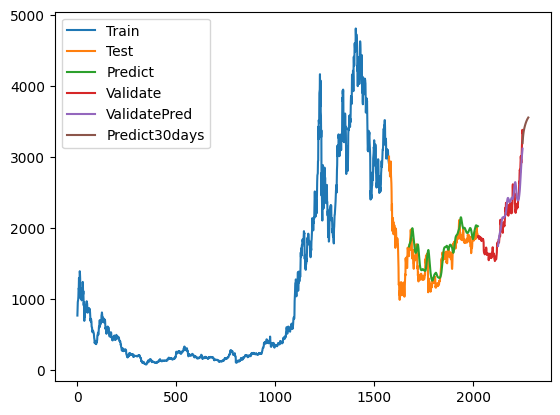

In [17]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()